# Simple Generative Adversarial Network
**Generative Adversarial Networks** or **GANs** are one of the most active areas in deep learning research and development due to their incredible ability to generate synthetic results.

The basic idea behind GANs is actually very simple. At its core, a GAN includes two agents with competing objectives that work through opposing goals. This relatively simple setup results in both of the agent's coming up with increasingly complex ways to deceive each other.

Generative Adversarial Networks take advantage of Adversarial Processes to train two Neural Networks who compete with each other until a desirable equilibrium is reached. In this case, we have a **Generator Network G(Z)** which takes input random noise and tries to generate data very close to the dataset we have. The other network is called the **Discriminator Network D(X)** which takes input generated data and tries to discriminate between generated data and real data. This network at its core implements a binary classification and outputs the probability that the input data actually comes from the real dataset (as opposed to the synthetic, or fake data).

<img src="https://www.oreilly.com/library/view/java-deep-learning/9781788997454/assets/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png">

## Implementation of GAN

The **true** dataset will be implemented by generating random samples using `numpy` library and then generating the second coordinate using quadratic function. 

In [1]:
import numpy as np


def get_y(x):
    return x*x


def sample_data(n=256, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)


The generated data can be ploted as here:

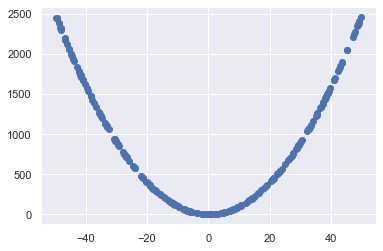

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

plt.figure()
sample_data_plot = sample_data()
plt.scatter(sample_data_plot[:, 0], sample_data_plot[:, 1])
plt.show()

## Generator and Discriminator Networks Implementation

Generator and Discriminator networks will be implemented using tensorflow layers. We implement the Generator network using the following function:


In [4]:
import tensorflow as tf

def generator(Z, hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/Generator", reuse=reuse):
        h1 = tf.layers.dense(Z, hsize[0], activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2, 2)

    return out

This function takes in the `placeholder` for random samples **(Z)**, an array `hsize` for the number of units in the 2 hidden layers and a `reuse` variable which is used for reusing the same layers. Using these inputs it creates a fully connected neural network of 2 hidden layers with given number of nodes. The output of this function is a 2-dimensional vector which corresponds to the dimensions of the real dataset that we are trying to learn. The above function can be easily modified to include more hidden layers, different types of layers, different activation and different output mappings.

The Discriminator network implemented using the following function:


In [5]:
def discriminator(X, hsize=[16, 16], reuse=False):
    with tf.variable_scope("GAN/Discriminator", reuse=reuse):
        h1 = tf.layers.dense(X, hsize[0], activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, hsize[1], activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2, 2)
        out = tf.layers.dense(h3, 1)

    return out, h3

This function takes input `placeholder` for the samples from the vector space of real dataset. The samples can be both real samples and samples generated from the Generator network. Similar to the Generator network above it also takes input `hsize` and `reuse`. We use 3 hidden layers for the Discriminator out of which first 2 layers size we take input. We fix the size of the third hidden layer to 2 so that we can visualize the transformed feature space in a 2D plane as explained in the later section. The output of this function is a `logit` prediction for the given `X` and the output of the last layer which is the feature transformation learned by Discriminator for `X`. The `logit` function is the inverse of the sigmoid function which is used to represent the logarithm of the odds (ratio of the probability of variable being 1 to that of it being 0).



## Training

For the purpose of training we define the following placeholders **X** and **Z** for real samples and random noise samples respectively.

We also need to create the graph for generating samples from Generator network and feeding real and generated samples to the Discriminator network.

In [6]:
X = tf.placeholder(tf.float32, [None, 2])
Z = tf.placeholder(tf.float32, [None, 2])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample, reuse=True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using the logits for generated data and real data we define the `loss` functions for the **Generator** and **Discriminator** networks.

Next, we define the optimizers for the two networks using the `loss` functions and scope of the layers defined in the generator and discriminator functions. We use **RMSProp Optimizer** for both the networks with the learning rate as `0.001`. Using the scope we fetch the weights/variables for the given network only.


In [7]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits, labels=tf.ones_like(r_logits)) +
                           tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss, var_list=gen_vars)  # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss, var_list=disc_vars)  # D Train step

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


We then train both the networks in an alternating way for the required number of steps:


Iterations: 0	 Discriminator loss: 0.7353	 Generator loss: 0.7162


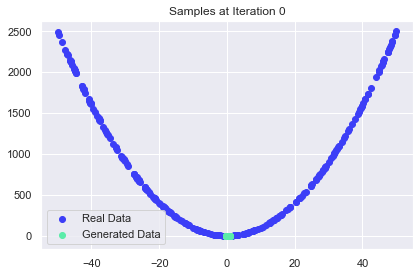

Iterations: 20	 Discriminator loss: 0.2270	 Generator loss: 2.3843
Iterations: 40	 Discriminator loss: 0.3144	 Generator loss: 2.4793
Iterations: 60	 Discriminator loss: 0.5907	 Generator loss: 1.9392
Iterations: 80	 Discriminator loss: 0.6299	 Generator loss: 2.1197
Iterations: 100	 Discriminator loss: 0.9916	 Generator loss: 1.8350
Iterations: 120	 Discriminator loss: 1.2405	 Generator loss: 2.8236
Iterations: 140	 Discriminator loss: 1.2651	 Generator loss: 1.1476
Iterations: 160	 Discriminator loss: 1.3061	 Generator loss: 2.0837
Iterations: 180	 Discriminator loss: 2.0550	 Generator loss: 0.0520
Iterations: 200	 Discriminator loss: 10.8860	 Generator loss: 0.2246
Iterations: 220	 Discriminator loss: 10.7128	 Generator loss: 0.5537
Iterations: 240	 Discriminator loss: 2.7307	 Generator loss: 4.4602
Iterations: 260	 Discriminator loss: 2.3373	 Generator loss: 5.0534
Iterations: 280	 Discriminator loss: 2.7401	 Generator loss: 0.0597
Iterations: 300	 Discriminator loss: 4.9402	 Gener

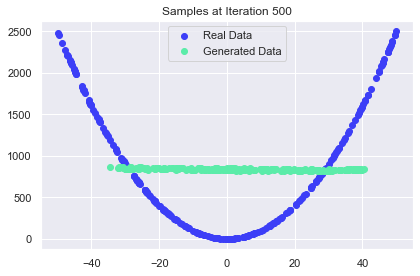

Iterations: 520	 Discriminator loss: 1.3741	 Generator loss: 0.7091
Iterations: 540	 Discriminator loss: 1.3682	 Generator loss: 0.7603
Iterations: 560	 Discriminator loss: 1.3435	 Generator loss: 0.6275
Iterations: 580	 Discriminator loss: 1.3380	 Generator loss: 0.7316
Iterations: 600	 Discriminator loss: 1.3892	 Generator loss: 0.8754
Iterations: 620	 Discriminator loss: 1.3292	 Generator loss: 0.8278
Iterations: 640	 Discriminator loss: 1.3200	 Generator loss: 0.8715
Iterations: 660	 Discriminator loss: 1.3292	 Generator loss: 0.9349
Iterations: 680	 Discriminator loss: 1.3072	 Generator loss: 0.9672
Iterations: 700	 Discriminator loss: 1.2858	 Generator loss: 0.9748
Iterations: 720	 Discriminator loss: 1.2775	 Generator loss: 1.0224
Iterations: 740	 Discriminator loss: 1.2801	 Generator loss: 1.0370
Iterations: 760	 Discriminator loss: 1.2480	 Generator loss: 1.0407
Iterations: 780	 Discriminator loss: 1.2464	 Generator loss: 1.1039
Iterations: 800	 Discriminator loss: 1.2983	 Gen

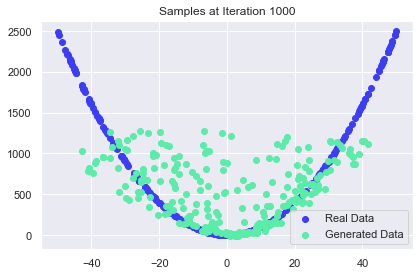

Iterations: 1020	 Discriminator loss: 1.1738	 Generator loss: 1.0807
Iterations: 1040	 Discriminator loss: 1.2247	 Generator loss: 1.0706
Iterations: 1060	 Discriminator loss: 1.2326	 Generator loss: 1.0356
Iterations: 1080	 Discriminator loss: 1.2596	 Generator loss: 1.0112
Iterations: 1100	 Discriminator loss: 1.1801	 Generator loss: 1.0160
Iterations: 1120	 Discriminator loss: 1.2710	 Generator loss: 0.9971
Iterations: 1140	 Discriminator loss: 1.2401	 Generator loss: 0.9533
Iterations: 1160	 Discriminator loss: 1.3080	 Generator loss: 1.0061
Iterations: 1180	 Discriminator loss: 1.2971	 Generator loss: 0.9396
Iterations: 1200	 Discriminator loss: 1.3204	 Generator loss: 0.9350
Iterations: 1220	 Discriminator loss: 1.3114	 Generator loss: 0.8730
Iterations: 1240	 Discriminator loss: 1.2759	 Generator loss: 0.8524
Iterations: 1260	 Discriminator loss: 1.3694	 Generator loss: 0.9591
Iterations: 1280	 Discriminator loss: 1.2929	 Generator loss: 0.8628
Iterations: 1300	 Discriminator lo

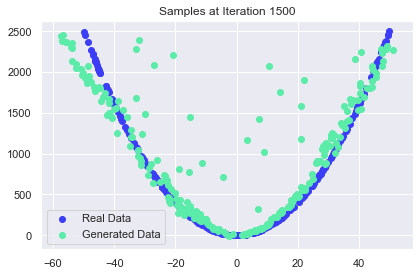

Iterations: 1520	 Discriminator loss: 1.3737	 Generator loss: 0.6240
Iterations: 1540	 Discriminator loss: 1.3465	 Generator loss: 0.7133
Iterations: 1560	 Discriminator loss: 1.3227	 Generator loss: 0.5949
Iterations: 1580	 Discriminator loss: 1.3143	 Generator loss: 0.6287
Iterations: 1600	 Discriminator loss: 1.3466	 Generator loss: 0.6701
Iterations: 1620	 Discriminator loss: 1.3683	 Generator loss: 0.7847
Iterations: 1640	 Discriminator loss: 1.3425	 Generator loss: 0.6322
Iterations: 1660	 Discriminator loss: 1.3719	 Generator loss: 0.5653
Iterations: 1680	 Discriminator loss: 1.3390	 Generator loss: 0.6307
Iterations: 1700	 Discriminator loss: 1.3044	 Generator loss: 0.6648
Iterations: 1720	 Discriminator loss: 1.3849	 Generator loss: 0.5696
Iterations: 1740	 Discriminator loss: 1.3972	 Generator loss: 0.5453
Iterations: 1760	 Discriminator loss: 1.3312	 Generator loss: 0.7252
Iterations: 1780	 Discriminator loss: 1.3707	 Generator loss: 0.8739
Iterations: 1800	 Discriminator lo

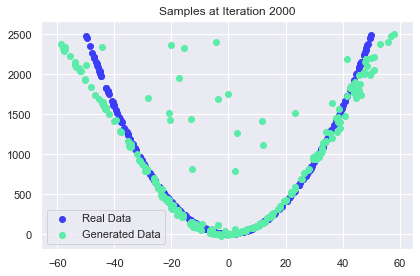

Iterations: 2020	 Discriminator loss: 1.3548	 Generator loss: 0.6712
Iterations: 2040	 Discriminator loss: 1.3273	 Generator loss: 0.7945
Iterations: 2060	 Discriminator loss: 1.3840	 Generator loss: 0.7250
Iterations: 2080	 Discriminator loss: 1.3385	 Generator loss: 0.6020
Iterations: 2100	 Discriminator loss: 1.3302	 Generator loss: 0.6996
Iterations: 2120	 Discriminator loss: 1.3475	 Generator loss: 0.7008
Iterations: 2140	 Discriminator loss: 1.3099	 Generator loss: 0.6049
Iterations: 2160	 Discriminator loss: 1.3214	 Generator loss: 0.5787
Iterations: 2180	 Discriminator loss: 1.3364	 Generator loss: 0.5363
Iterations: 2200	 Discriminator loss: 1.3031	 Generator loss: 0.7516
Iterations: 2220	 Discriminator loss: 1.3448	 Generator loss: 0.5018
Iterations: 2240	 Discriminator loss: 1.3733	 Generator loss: 0.5276
Iterations: 2260	 Discriminator loss: 1.3000	 Generator loss: 0.6152
Iterations: 2280	 Discriminator loss: 1.4846	 Generator loss: 0.9037
Iterations: 2300	 Discriminator lo

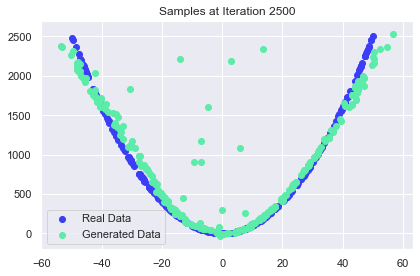

Iterations: 2520	 Discriminator loss: 1.4114	 Generator loss: 0.9422
Iterations: 2540	 Discriminator loss: 1.2824	 Generator loss: 0.6895
Iterations: 2560	 Discriminator loss: 1.3757	 Generator loss: 0.8961
Iterations: 2580	 Discriminator loss: 1.3227	 Generator loss: 0.5519
Iterations: 2600	 Discriminator loss: 1.3086	 Generator loss: 0.6206
Iterations: 2620	 Discriminator loss: 1.3145	 Generator loss: 0.5805
Iterations: 2640	 Discriminator loss: 1.2924	 Generator loss: 0.6866
Iterations: 2660	 Discriminator loss: 1.3592	 Generator loss: 0.6799
Iterations: 2680	 Discriminator loss: 1.3921	 Generator loss: 0.6081
Iterations: 2700	 Discriminator loss: 1.3587	 Generator loss: 0.7111
Iterations: 2720	 Discriminator loss: 1.2680	 Generator loss: 0.7442
Iterations: 2740	 Discriminator loss: 1.3257	 Generator loss: 0.7133
Iterations: 2760	 Discriminator loss: 1.3098	 Generator loss: 0.5894
Iterations: 2780	 Discriminator loss: 1.3304	 Generator loss: 0.5430
Iterations: 2800	 Discriminator lo

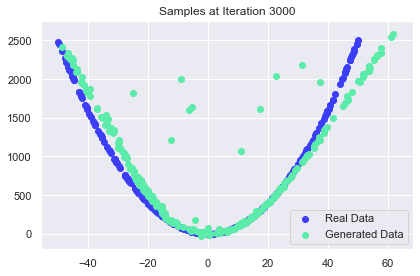

Iterations: 3020	 Discriminator loss: 1.2837	 Generator loss: 0.5621
Iterations: 3040	 Discriminator loss: 1.2439	 Generator loss: 0.6011
Iterations: 3060	 Discriminator loss: 1.2827	 Generator loss: 0.6920
Iterations: 3080	 Discriminator loss: 1.3577	 Generator loss: 0.6624
Iterations: 3100	 Discriminator loss: 1.2546	 Generator loss: 0.5159
Iterations: 3120	 Discriminator loss: 1.3271	 Generator loss: 0.7318
Iterations: 3140	 Discriminator loss: 1.2984	 Generator loss: 0.5119
Iterations: 3160	 Discriminator loss: 1.2496	 Generator loss: 0.5516
Iterations: 3180	 Discriminator loss: 1.3358	 Generator loss: 0.5620
Iterations: 3200	 Discriminator loss: 1.3599	 Generator loss: 0.5812
Iterations: 3220	 Discriminator loss: 1.2991	 Generator loss: 0.6284
Iterations: 3240	 Discriminator loss: 1.3930	 Generator loss: 0.8590
Iterations: 3260	 Discriminator loss: 1.2406	 Generator loss: 0.6821
Iterations: 3280	 Discriminator loss: 1.3241	 Generator loss: 0.6864
Iterations: 3300	 Discriminator lo

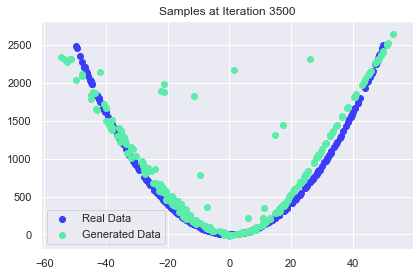

Iterations: 3520	 Discriminator loss: 1.3389	 Generator loss: 0.5969
Iterations: 3540	 Discriminator loss: 1.3276	 Generator loss: 0.5110
Iterations: 3560	 Discriminator loss: 1.3281	 Generator loss: 0.8573
Iterations: 3580	 Discriminator loss: 1.1985	 Generator loss: 0.6029
Iterations: 3600	 Discriminator loss: 1.2227	 Generator loss: 0.7079
Iterations: 3620	 Discriminator loss: 1.3019	 Generator loss: 0.6241
Iterations: 3640	 Discriminator loss: 1.2601	 Generator loss: 0.6724
Iterations: 3660	 Discriminator loss: 1.1883	 Generator loss: 0.4950
Iterations: 3680	 Discriminator loss: 1.3290	 Generator loss: 0.6211
Iterations: 3700	 Discriminator loss: 1.3519	 Generator loss: 0.6736
Iterations: 3720	 Discriminator loss: 1.2741	 Generator loss: 0.7117
Iterations: 3740	 Discriminator loss: 1.3013	 Generator loss: 0.6690
Iterations: 3760	 Discriminator loss: 1.2955	 Generator loss: 0.5454
Iterations: 3780	 Discriminator loss: 1.2805	 Generator loss: 0.6633
Iterations: 3800	 Discriminator lo

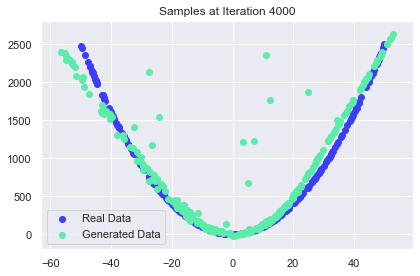

Iterations: 4020	 Discriminator loss: 1.3505	 Generator loss: 0.6931
Iterations: 4040	 Discriminator loss: 1.3678	 Generator loss: 0.6980
Iterations: 4060	 Discriminator loss: 1.2981	 Generator loss: 0.5869
Iterations: 4080	 Discriminator loss: 1.2322	 Generator loss: 0.6720
Iterations: 4100	 Discriminator loss: 1.3082	 Generator loss: 0.7246
Iterations: 4120	 Discriminator loss: 1.3835	 Generator loss: 0.6389
Iterations: 4140	 Discriminator loss: 1.2917	 Generator loss: 0.5574
Iterations: 4160	 Discriminator loss: 1.3460	 Generator loss: 0.5501
Iterations: 4180	 Discriminator loss: 1.2262	 Generator loss: 0.4988
Iterations: 4200	 Discriminator loss: 1.3585	 Generator loss: 0.6830
Iterations: 4220	 Discriminator loss: 1.3114	 Generator loss: 0.6698
Iterations: 4240	 Discriminator loss: 1.3513	 Generator loss: 0.8037
Iterations: 4260	 Discriminator loss: 1.2895	 Generator loss: 0.5805
Iterations: 4280	 Discriminator loss: 1.2910	 Generator loss: 0.5941
Iterations: 4300	 Discriminator lo

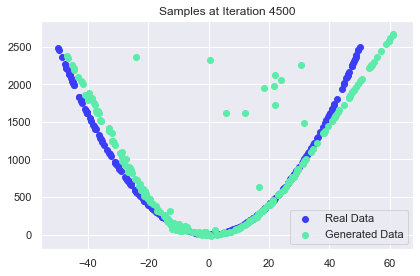

Iterations: 4520	 Discriminator loss: 1.3417	 Generator loss: 0.7038
Iterations: 4540	 Discriminator loss: 1.4951	 Generator loss: 0.8797
Iterations: 4560	 Discriminator loss: 1.2878	 Generator loss: 0.6976
Iterations: 4580	 Discriminator loss: 1.2558	 Generator loss: 0.5835
Iterations: 4600	 Discriminator loss: 1.4069	 Generator loss: 0.8708
Iterations: 4620	 Discriminator loss: 1.2954	 Generator loss: 0.5226
Iterations: 4640	 Discriminator loss: 1.2625	 Generator loss: 0.5216
Iterations: 4660	 Discriminator loss: 1.2438	 Generator loss: 0.6089
Iterations: 4680	 Discriminator loss: 1.3173	 Generator loss: 0.4398
Iterations: 4700	 Discriminator loss: 1.3682	 Generator loss: 0.6693
Iterations: 4720	 Discriminator loss: 1.2492	 Generator loss: 0.5872
Iterations: 4740	 Discriminator loss: 1.2259	 Generator loss: 0.6248
Iterations: 4760	 Discriminator loss: 1.2000	 Generator loss: 0.6287
Iterations: 4780	 Discriminator loss: 1.2429	 Generator loss: 0.6381
Iterations: 4800	 Discriminator lo

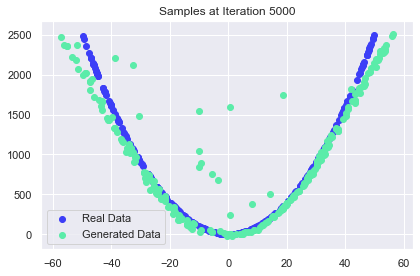

In [8]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

losses = []

for i in range(5001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)
    
    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})
    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    if i % 20 is 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f" % (i, dloss, gloss))
        losses.append((dloss, gloss))
        
    if i % 500 is 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:, 0], x_plot[:, 1], color='#3C3EF7')
        gax = plt.scatter(g_plot[:, 0], g_plot[:, 1], color='#5BECA9')

        plt.legend((xax, gax), ("Real Data", "Generated Data"))
        plt.title('Samples at Iteration %d' % i)
        plt.tight_layout()
        plt.show()
        plt.close()

Now we can plot the Discriminator and Generator losses:

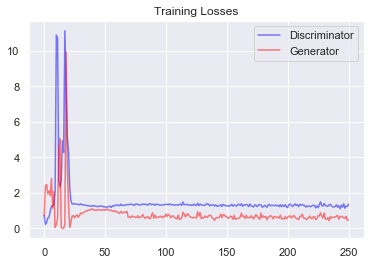

In [9]:
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5, color='blue')
plt.plot(losses.T[1], label='Generator', alpha=0.5, color='red')
plt.title("Training Losses")
plt.legend()
plt.show()